In [1]:
import numpy as np
import pandas as pd
import os
import sys
import torch
sys.path.append(os.getcwd())

import trainer
import utils
from missing_util import introduce_mising, preprocessing,introduce_mising_middle
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
url1 = "https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt"

In [3]:
def preprocessing1(data):
    # ---- drop the classification attribute
    data = data[:, :-1]
    np.random.shuffle(data)
    # ----
    N, D = data.shape
    dl = D - 1
    # ---- standardize data
    data = data - np.mean(data, axis=0)
    data = data / np.std(data, axis=0)

    # ---- random permutation
    p = np.random.permutation(N)
    data = data[p, :]

    Xtrain = data.copy()
    Xval_org = data.copy()

    return data.shape, Xtrain, Xval_org, dl

In [4]:
def random_missing(array, fractions_to_change):
    """
    Randomly changes a fraction of the True values in each column of a boolean array to False.

    Args:
        array (numpy.ndarray): The input boolean array.
        fractions_to_change (list or numpy.ndarray): The fractions of True values to change to False in each column.

    Returns:
        result (numpy.ndarray): The boolean array with the specified fractions of True values changed to False in each column.
    """

    result = array.copy()
    for col in range(result.shape[1]):
        col_array = result[:, col]
        # if need to change to multiple conversion rate
        #n_to_change = int(np.sum(col_array) * fractions_to_change[col])
        n_to_change = int(np.sum(col_array) * fractions_to_change)
        ix_to_change = np.random.choice(np.flatnonzero(col_array), size=n_to_change, replace=False)

        col_array[ix_to_change] = False

    return result

In [5]:
testbl = np.array([[True,False,True],[True,False,True],[True,False,True],[True,False,True],[True,False,True],[True,False,True],[True,False,True],[True,False,True],[True,False,True],[True,False,True]])

In [6]:
def generate_middle(lower,upper,partial_missing,dataset,missing_dim):
    if lower == 0:
        lower_quantile = np.min(dataset[:, :missing_dim], axis=0)
    else:
        lower_quantile = np.quantile(dataset[:, :missing_dim],lower, axis=0)
    if upper == 1:
        upper_quantile = np.max(dataset[:, :missing_dim], axis=0)
    else:
        upper_quantile = np.quantile(dataset[:, :missing_dim],upper, axis=0)



    ix_larger_than = dataset[:, :missing_dim] >= lower_quantile
    ix_smaller_than = dataset[:, :missing_dim] <= upper_quantile
    combined_ix = np.equal(ix_larger_than, ix_smaller_than)
    combined_ix = random_missing(combined_ix,partial_missing)
    
    return combined_ix

In [7]:
def missing_by_range(X,multiple_block,missing_dim=1):
    """    
    Missing_quantile: value is larger than quantile will be missing
    Missing_dim: how many columns have missing data
    Partial_missing: if partially or completely missing (default=0, partial_missing rate = 0), 
                    if larger means left more data
    Missing_type: middle, outside, multiple
    """

    N, D = X.shape
    Xnan = X.copy()

    # ---- Missing Dimention
    missing_dim = int(missing_dim * D)
    
    ix_list = []
    for key in multiple_block.keys():
        info = multiple_block[key]
        combined_ix = generate_middle(info["lower"],info["upper"],info["partial_missing"], X, missing_dim)
        ix_list.append(combined_ix)
    combined_ix = np.logical_or.reduce(ix_list)
    

    Xnan[:, :missing_dim][combined_ix] = np.nan

    Xz = Xnan.copy()
    Xz[np.isnan(Xnan)] = 0

    return Xnan, Xz

In [8]:
data = np.array([[0,0,0],[2,2,2],[3,3,3],[4,4,4],[5,5,5],[6,6,6.1],[7,7,7],[8,8,8],[9,9,9],[11,11,11]])
dataset  = np.array(pd.read_csv(url1, low_memory=False, sep=','))
data_shape, Xtrain, Xval_org, dl = preprocessing1(dataset)

In [9]:
multiple_block = {1:{"lower": 0.75,"upper":1,"partial_missing":0.}
                  #,2:{"lower": 0.5,"upper":0.6,"partial_missing":0.}
                  #,3:{"lower": 0.8,"upper":0.9,"partial_missing":0.}
                  }
Xnan, Xz = missing_by_range(data, multiple_block)
print(Xnan)

[[0.  0.  0. ]
 [2.  2.  2. ]
 [3.  3.  3. ]
 [4.  4.  4. ]
 [5.  5.  5. ]
 [6.  6.  6.1]
 [7.  7.  7. ]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]]


In [115]:
q1 = {"1": {"lower": 0.0, "upper": 0.25, "partial_missing": 0.5}}

In [116]:
Xnan, Xz = missing_by_range(Xtrain, q1)
#compare_distributions(Xtrain, Xnan,"test", False)

In [114]:
q1

{'1': {'lower': 0.0, 'upper': 0.25, 'partial_missing': 0.0}}

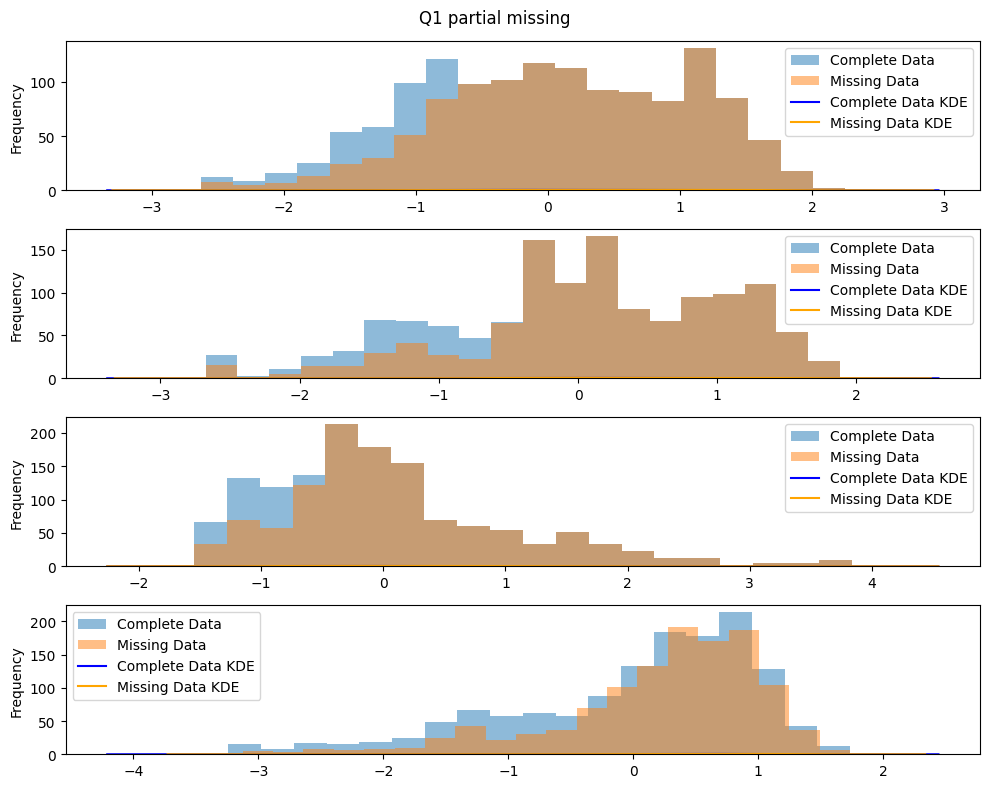

In [118]:
compare_distributions(Xtrain, Xnan,"Q1 partial missing", False)

In [50]:
data = np.array([[0,0,0],[2,2,2],[3,3,3],[4,4,4],[5,5,5],[6,6,6.1],[7,7,7],[8,8,8],[9,9,9],[11,11,11]])
data = np.array([sorted(np.random.uniform(0.0, 100, 100).round(1)),sorted(np.random.uniform(0.0, 100, 100).round(1)),sorted(np.random.uniform(0.0, 100, 100).round(1)),sorted(np.random.uniform(0.0, 100, 100).round(1)),sorted(np.random.uniform(0.0, 100, 100).round(1)),sorted(np.random.uniform(0.0, 100, 100).round(1))]).T

In [51]:
data

array([[  0.3,   1.9,   1.6,   0.2,   0.3,   0.2],
       [  0.6,   2.3,   1.9,   2.3,   2.6,   2. ],
       [  0.6,   2.8,   1.9,   2.3,   5.2,   2.4],
       [  0.9,   4.1,   3.8,   4.5,   5.2,   3.5],
       [  1.1,   4.7,   4.7,   5.5,   9.1,   3.5],
       [  3.5,   5. ,   5.3,   7.1,  10.5,   4.5],
       [  4.8,   5. ,   5.3,   7.5,  11.4,   5.8],
       [  5.6,   5. ,   6.8,   7.7,  11.6,   8.3],
       [  6.3,   6.3,   7.3,   8.2,  13.5,   9.2],
       [  7.9,   6.5,   8.3,   8.6,  14. ,  10.2],
       [  9.8,   9.5,   8.5,   9.3,  15.4,  10.6],
       [ 10.1,   9.7,   8.5,  10.4,  15.5,  11.1],
       [ 10.5,  11.1,   9.9,  11.4,  16. ,  12.8],
       [ 10.7,  11.5,  10.2,  12. ,  16.2,  13.8],
       [ 11.2,  13.3,  11.1,  13. ,  18.4,  14.3],
       [ 12.4,  16.5,  12.5,  14.4,  18.5,  15.7],
       [ 13.2,  18.7,  14.1,  15. ,  20.6,  16.3],
       [ 13.6,  18.8,  14.4,  15.7,  20.8,  16.4],
       [ 14.3,  19.4,  16.4,  15.8,  21. ,  16.6],
       [ 14.5,  19.5,  17.2,  1

In [10]:
def compare_distributions(complete_data, missing_data,title,density = True
                          ,bins=20
                          ):
    """
    Plots histograms and kernel density estimates for each dimension of a complete dataset and a dataset with missing data.
    
    Parameters:
        complete_data (np.ndarray): A complete dataset with an arbitrary number of dimensions.
        missing_data (np.ndarray): A dataset with missing data. Must have the same shape as `complete_data`.
        bins (int): The number of bins to use for the histograms.
    
    Returns:
        None
    """
    num_dims = complete_data.shape[1]
    fig, axs = plt.subplots(nrows=num_dims, ncols=1, figsize=(10, 2*num_dims))
    plt.suptitle(title)

    for i in range(num_dims):
        axs[i].hist(complete_data[:, i], alpha=0.5, 
                    bins=bins, 
                    density=density, label='Complete Data')
        axs[i].hist(missing_data[:, i], alpha=0.5, 
                    bins=bins, 
                    density=density, label='Missing Data')
        sns.kdeplot(complete_data[:, i], ax=axs[i], color='blue', label='Complete Data KDE')
        sns.kdeplot(missing_data[:, i], ax=axs[i], color='orange', label='Missing Data KDE')
        #axs[i].set_xlabel(f'Dimension {i+1}')
        if not density:
            axs[i].set_ylabel('Frequency')
        else:
            axs[i].set_ylabel('Density')
        axs[i].legend()

    plt.tight_layout()
    plt.savefig("plots/{}.png".format(title))
    plt.show()

In [11]:

def pick_coeffs(X, idxs_obs=None, idxs_nas=None, self_mask=False):
    n, d = X.shape
    if self_mask:
        coeffs = torch.randn(d)
        Wx = X * coeffs
        coeffs /= torch.std(Wx, 0)
    else:
        d_obs = len(idxs_obs)
        d_na = len(idxs_nas)
        
        coeffs = torch.randn(d_obs, d_na)
        # Normal distribution sample
        #  matrix multiplicatio
        Wx = X[:, idxs_obs].mm(coeffs)
        coeffs /= torch.std(Wx, 0, keepdim=True)
    return coeffs

In [12]:
from utils_generation import *
import torch

In [13]:

def MNAR_mask_logistic(X, p, p_params =.3, exclude_inputs=True):
    """
    Missing not at random mechanism with a logistic masking model. It implements two mechanisms:
    (i) Missing probabilities are selected with a logistic model, taking all variables as inputs. Hence, values that are
    inputs can also be missing.
    (ii) Variables are split into a set of intputs for a logistic model, and a set whose missing probabilities are
    determined by the logistic model. Then inputs are then masked MCAR (hence, missing values from the second set will
    depend on masked values.
    In either case, weights are random and the intercept is selected to attain the desired proportion of missing values.

    """

    n, d = X.shape

    to_torch = torch.is_tensor(X) ## output a pytorch tensor, or a numpy array
    if not to_torch:
        X = torch.from_numpy(X)

    mask = torch.zeros(n, d).bool() if to_torch else np.zeros((n, d)).astype(bool)

    d_params = max(int(p_params * d), 1) if exclude_inputs else d ## number of variables used as inputs (at least 1)
    d_na = d - d_params if exclude_inputs else d ## number of variables masked with the logistic model

    ### Sample variables that will be parameters for the logistic regression:
    idxs_params = np.random.choice(d, d_params, replace=False) if exclude_inputs else np.arange(d)
    idxs_nas = np.array([i for i in range(d) if i not in idxs_params]) if exclude_inputs else np.arange(d)

    ### Other variables will have NA proportions selected by a logistic model
    ### The parameters of this logistic model are random.

    ### Pick coefficients so that W^Tx has unit variance (avoids shrinking)
    coeffs = pick_coeffs(X, idxs_params, idxs_nas)
    ### Pick the intercepts to have a desired amount of missing values
    intercepts = fit_intercepts(X[:, idxs_params], coeffs, p)

    ps = torch.sigmoid(X[:, idxs_params].mm(coeffs) + intercepts)

    ber = torch.rand(n, d_na)
    mask[:, idxs_nas] = ber < ps

    ## If the inputs of the logistic model are excluded from MNAR missingness,
    ## mask some values used in the logistic model at random.
    ## This makes the missingness of other variables potentially dependent on masked values

    if exclude_inputs:
        mask[:, idxs_params] = torch.rand(n, d_params) < p

    return mask

In [14]:
dataset  = np.array(pd.read_csv(url1, low_memory=False, sep=','))
data_shape, Xtrain, Xval_org, dl = preprocessing1(dataset)

In [103]:
Xnan, Xz = OT_missing(Xtrain, 0.55 , "MNAR","selfmasked",0.4, 0.4)
#Xnan, Xz = OT_missing(data, 0.25 , "MNAR","quantile",0.4, 0.4)
# "logistic","selfmasked","quantile"

MANR with selfmasked Mask


In [80]:
Xnan.round(3)

array([[-0.969,  0.213, -0.557, -0.725],
       [ 1.14 ,  0.184, -0.127,  0.714],
       [ 0.223,  0.303, -1.29 , -0.355],
       ...,
       [   nan, -2.118,  1.769,    nan],
       [-0.857,    nan,  1.841,  0.518],
       [ 0.257,  1.428, -0.623,    nan]])

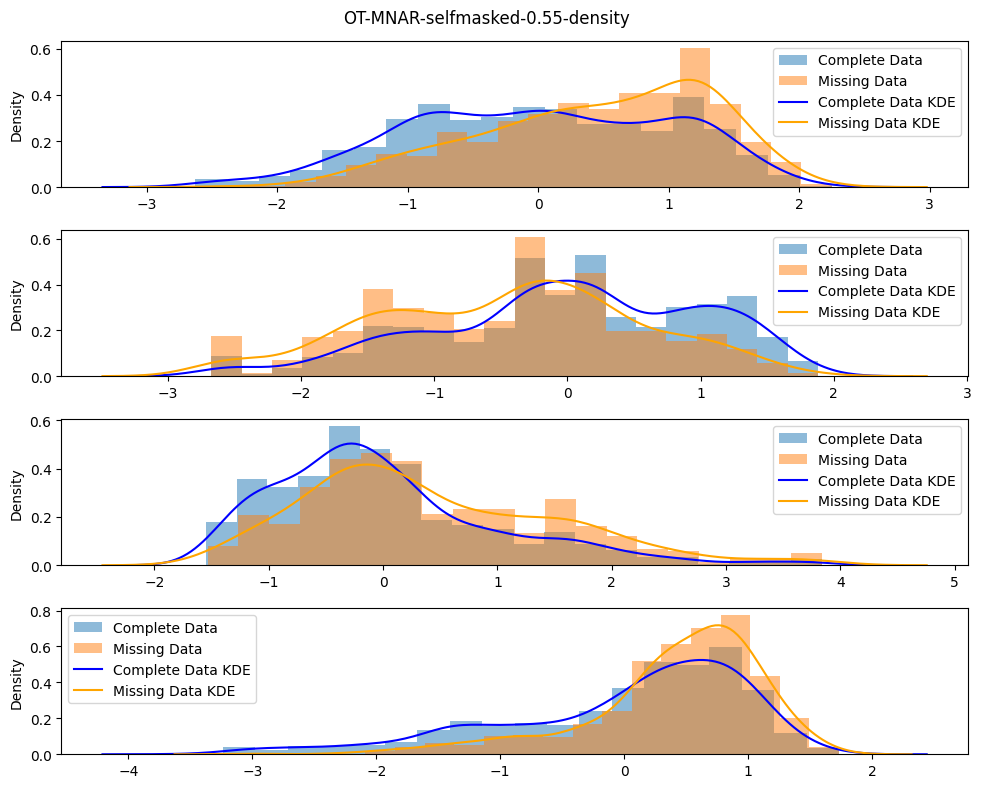

In [106]:
compare_distributions(Xtrain, Xnan,"OT-MNAR-selfmasked-0.55-density", True)

In [15]:
def produce_NA(X, p_miss, mecha="MCAR", opt=None, p_obs=0.2, q=None):
    """
    Generate missing values for specifics missing-data mechanism and proportion of missing values. 
    
    Parameters
    ----------
    X : torch.DoubleTensor or np.ndarray, shape (n, d)
        Data for which missing values will be simulated.
        If a numpy array is provided, it will be converted to a pytorch tensor.
    p_miss : float
        Proportion of missing values to generate for variables which will have missing values.
    mecha : str, 
            Indicates the missing-data mechanism to be used. "MCAR" by default, "MAR", "MNAR" or "MNARsmask"
    opt: str, 
         For mecha = "MNAR", it indicates how the missing-data mechanism is generated: using a logistic regression ("logistic"), quantile censorship ("quantile") or logistic regression for generating a self-masked MNAR mechanism ("selfmasked").
    p_obs : float
            If mecha = "MAR", or mecha = "MNAR" with opt = "logistic" or "quanti", proportion of variables with *no* missing values that will be used for the logistic masking model.
    q : float
        If mecha = "MNAR" and opt = "quanti", quantile level at which the cuts should occur.
    
    Returns
    ----------
    A dictionnary containing:
    'X_init': the initial data matrix.
    'X_incomp': the data with the generated missing values.
    'mask': a matrix indexing the generated missing values.s
    """
    
    to_torch = torch.is_tensor(X) ## output a pytorch tensor, or a numpy array
    if not to_torch:
        X = X.astype(np.float32)
        X = torch.from_numpy(X)
    
    if mecha == "MAR":
        print("MAR")
        mask = MAR_mask(X, p_miss, p_obs).double()
    elif mecha == "MNAR" and opt == "logistic":
        print("MANR with logistic Mask")
        mask = MNAR_mask_logistic(X, p_miss, p_obs).double()
    elif mecha == "MNAR" and opt == "quantile":
        print("MANR with quantile Mask")
        mask = MNAR_mask_quantiles(X, p_miss, q, 1-p_obs).double()
    elif mecha == "MNAR" and opt == "selfmasked":
        print("MANR with selfmasked Mask")
        mask = MNAR_self_mask_logistic(X, p_miss).double()
    else:
        print("MCAR")
        mask = (torch.rand(X.shape) < p_miss).double()
    
    X_nas = X.clone()
    X_nas[mask.bool()] = np.nan
    
    return {'X_init': X.double(), 'X_incomp': X_nas.double(), 'mask': mask}

In [61]:

def OT_missing(X, p, missing_mecha,opt, p_obs, q):
    N, D = X.shape
    Xnan = X.copy()


    X_miss_mcar = produce_NA(X, p_miss=p, mecha= missing_mecha, opt = opt, p_obs = p_obs, q=q)

    Xnan = X_miss_mcar['X_incomp'].numpy()
    Xz = Xnan.copy()
    Xz[np.isnan(Xnan)] = 0

    return Xnan, Xz
